## HW2

> using ResNext

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check python, system version
!python -V
!nvcc --version

Python 3.7.13
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!pip3 uninstall torch torchvision torchaudio
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu102

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.0+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/pyth

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.12.0.dev20220413+cu102
0.13.0.dev20220414+cu102


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# see more data augmentation https://pytorch.org/vision/stable/transforms.html
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]) # calculte yourself

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]) # calculte yourself

batch_size = 64
num_classes = 100    # check

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# pick one

# 1. model defined by yourself
# model = my_CNN()        
   
# 2. off-the-shelf model
# see https://pytorch.org/vision/stable/models.html
# nn.Linear https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

model = models.resnext50_32x4d(pretrained=True)
model.conv1 = nn.Conv2d(3,64,kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model.maxpool = nn.Identity()
model.fc = torch.nn.Linear(2048, num_classes)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, e

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

In [7]:
total_epoch = 200
print_per_iteration = 100
acc_list = []
max_acc = (0,0)

for epoch in range(total_epoch):  # loop over the dataset multiple times
    model.train()
    save_path = '/content/drive/MyDrive/Colab Notebooks/ML_HW2/myCNN_test/ResNext50.pth'
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        # if (i+1) % print_per_iteration == 0:    # print every 2000 mini-batches
        #     print(f'[ep {epoch + 1}][{i + 1:5d}/{len(trainloader):5d}] loss: {loss.item():.3f}')
    # torch.save(model, save_path)

    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            n_acc = correct/total
    print(f'Accuracy of epoch {epoch+1} : {100 * correct / total:.2f} %')
    acc_list.append(n_acc)
      
    if n_acc > max_acc[0] :
      max_acc = (n_acc,epoch)
      torch.save(model, save_path)

Accuracy of epoch 1 : 11.86 %
Accuracy of epoch 2 : 21.78 %
Accuracy of epoch 3 : 29.32 %
Accuracy of epoch 4 : 36.65 %
Accuracy of epoch 5 : 42.18 %
Accuracy of epoch 6 : 47.45 %
Accuracy of epoch 7 : 52.12 %
Accuracy of epoch 8 : 55.13 %
Accuracy of epoch 9 : 57.95 %
Accuracy of epoch 10 : 60.87 %
Accuracy of epoch 11 : 62.55 %
Accuracy of epoch 12 : 64.42 %
Accuracy of epoch 13 : 65.67 %
Accuracy of epoch 14 : 66.95 %
Accuracy of epoch 15 : 67.94 %
Accuracy of epoch 16 : 68.89 %
Accuracy of epoch 17 : 69.50 %
Accuracy of epoch 18 : 70.31 %
Accuracy of epoch 19 : 70.86 %
Accuracy of epoch 20 : 71.15 %
Accuracy of epoch 21 : 71.52 %
Accuracy of epoch 22 : 71.93 %
Accuracy of epoch 23 : 72.42 %
Accuracy of epoch 24 : 72.44 %
Accuracy of epoch 25 : 72.68 %
Accuracy of epoch 26 : 73.11 %
Accuracy of epoch 27 : 73.14 %
Accuracy of epoch 28 : 73.36 %
Accuracy of epoch 29 : 73.66 %
Accuracy of epoch 30 : 73.61 %
Accuracy of epoch 31 : 73.51 %
Accuracy of epoch 32 : 73.80 %
Accuracy of epoch

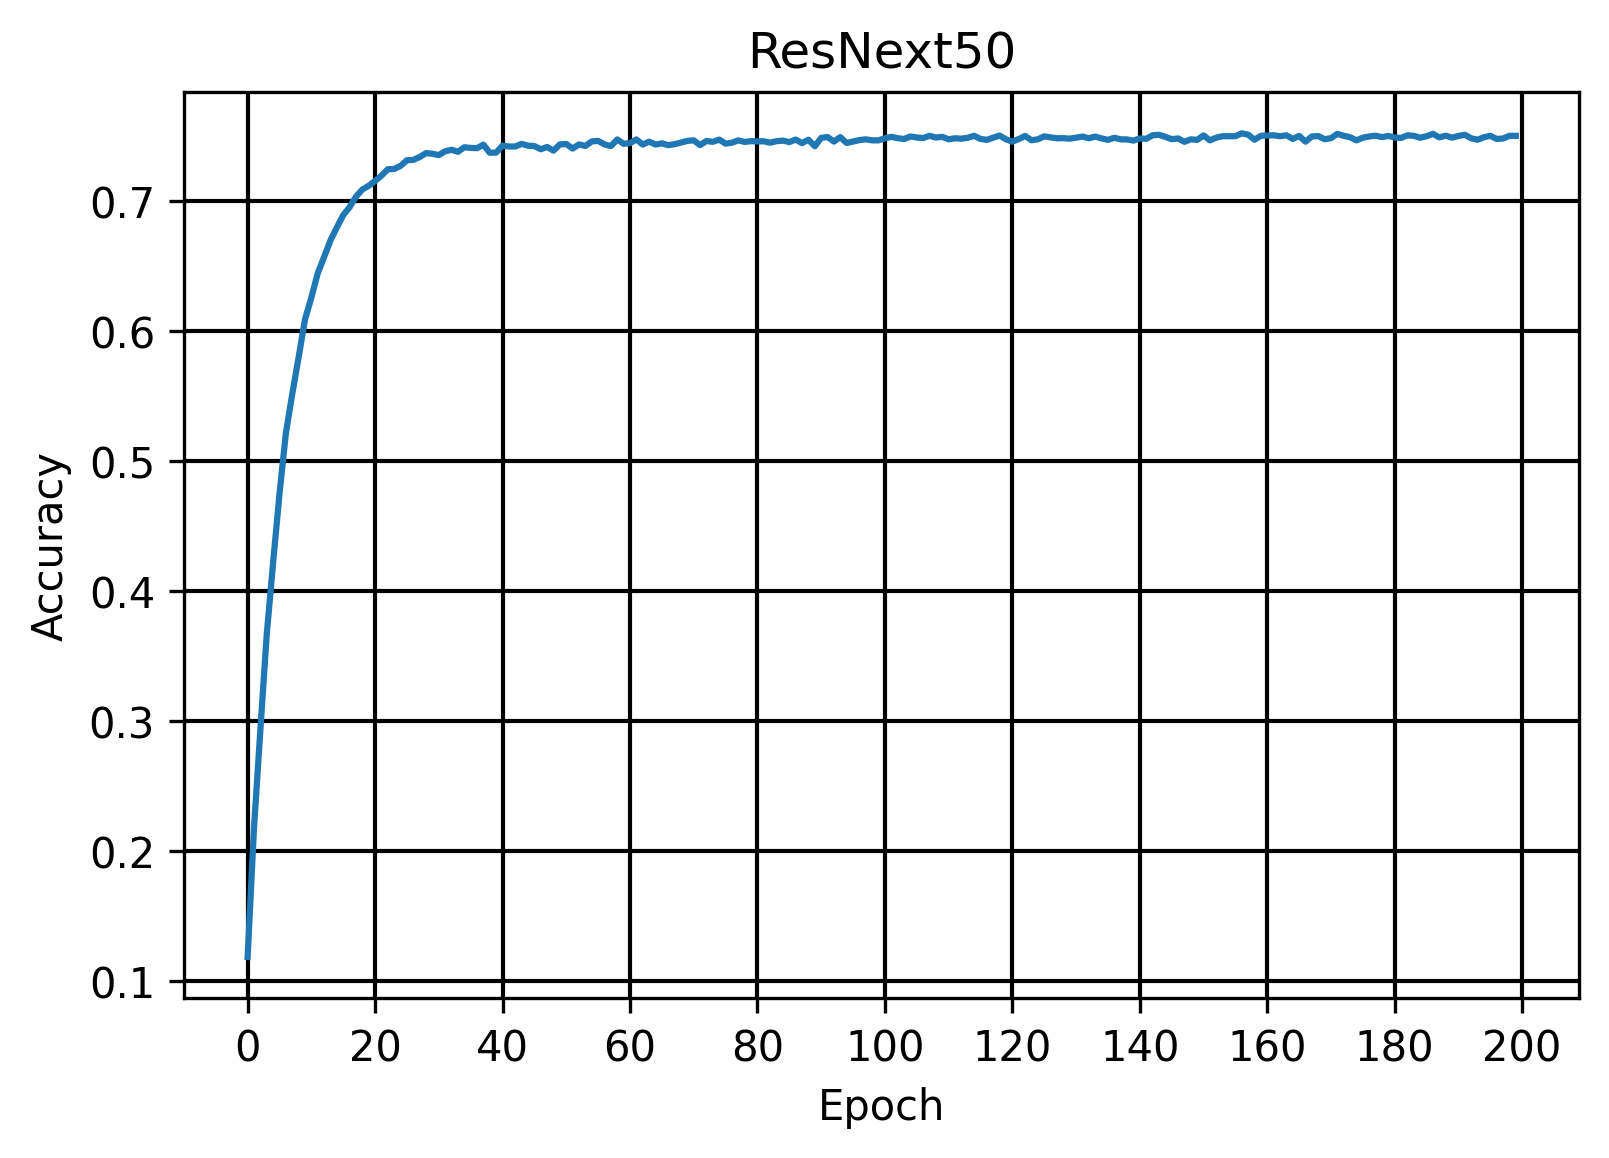

(0.7518, 156)


In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = range(0,200,1)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.plot(x,acc_list)
plt.xticks(np.arange(0,220,step=20))
plt.title('ResNext50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(color='black', linestyle='-', linewidth='1')
plt.show()

print(max_acc)